In [1]:
import time
from pathlib import Path
import numpy as np
from scipy.linalg import block_diag
import torch

from cfg import parse_cfg
from algorithm.helper import set_seed
from envs import LQ, make_env
from algorithm.models import quad_tank_model, linear_quad_tank_model
from visualization.visualize_helper import *

work_dir = Path().cwd()

data_save_dir = work_dir.parents[0] / "logs" / "timings"
if not data_save_dir.exists():
    Path.mkdir(data_save_dir)

fig_save_dir = work_dir / "visualization" / "sample_figures" / "timings"
if not fig_save_dir.exists():
    Path.mkdir(fig_save_dir)

/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Linear system

### State (n) Timings

In [2]:
cfg = parse_cfg(work_dir.parents[0] / "cfgs" / 'LQ_base.yaml')

n = 4
m = 1
cfg.n = n
cfg.m = m

In [3]:
def get_x0AB_n(n, cfg):
    env = LQ(cfg)
    x0 = env.reset(1)
    A = env.A
    B = env.B

    nb = (n // 4) + 1
    As = [A]*(nb)
    Bs = [B]*(nb)
    x0s = [x0]*(nb)
    A_tch =  torch.from_numpy(block_diag(*As)[:n,:n]).float().requires_grad_()
    B_tch =  torch.from_numpy(np.concatenate(Bs)[:n]).float().requires_grad_()
    x0_tch = torch.from_numpy(np.concatenate(x0s, axis=-1)[...,:n]).float().requires_grad_()

    return (x0_tch, A_tch, B_tch)

N = [4,8,16,32,64]
pis = [None] * len(N)
for i, n in enumerate(N):
    cfg.n = n
    pis[i] = construct_pi(cfg)

In [4]:
set_seed(42)
T = 10
n_traj_samples = 64
n_samples = n_traj_samples*T
n_timings = np.zeros((len(N), 2, n_samples))

for i, n in enumerate(N):
    x0_tch, A_tch, B_tch = get_x0AB_n(n, cfg)
    u = pis[i](x0_tch, A_tch, B_tch)
    pi_optim = torch.optim.Adam([A_tch, B_tch], lr=cfg.lr)
    pi_optim.zero_grad()
    u[0].backward()
    for j in range(n_traj_samples):
        x0_tch, A_tch, B_tch = get_x0AB_n(n, cfg)
        for t in range(T):
            u = pis[i](x0_tch, A_tch, B_tch) 
            pi_optim.zero_grad()
            start = time.time() 
            u[0].backward()
            end = time.time() - start
            n_timings[i,:,j*T+t] = np.array([
                pis[i].info['solve_time'],
                end - pis[i].info['dcanon_time'],            
            ])
            with torch.no_grad():
                x0_tch = x0_tch @ A_tch.T + B_tch.flatten() * u[0]

np.save(data_save_dir / "input_n_timings", n_timings, allow_pickle=False)

In [5]:
n_timings = np.load(data_save_dir / "input_n_timings.npy")
avg_n_timings = np.average(n_timings,axis=-1)
std_n_timings = np.std(n_timings,axis=-1)
n_data = {
    "Solving OCP": n_timings[:,0], # np.array([frob_RNF_B, frob_BO_B])
    "Implicit Differentiation": n_timings[:,1]
}

# plot_double_bar(methods=N, data=n_data, xlabel="n", w=0.4, fn = save_dir / "input_n_double_bar_plot.png")

### Input (m) Timings

In [6]:
cfg = parse_cfg(work_dir.parents[0] / "cfgs" / 'LQ_base.yaml')
n = 4
m = 1
cfg.n = n
cfg.m = m

In [7]:
# res = np.max(res[-2]), methods[best_RNF_none[0]], batch_sizes[best_RNF_none[1]], batches[best_RNF_none[2]], valid_seeds[best_RNF_none[3]]
def get_x0AB_m(m, cfg):
    env = LQ(cfg)
    x0 = env.reset(1)
    A = env.A
    B = env.B

    Bs = [B for i in range(m)] # [B]*(nb)
    A_tch =  torch.from_numpy(A).float().requires_grad_()
    B_tch =  torch.from_numpy(np.concatenate(Bs, axis=1)).float().requires_grad_()
    x0_tch = torch.from_numpy(x0).float().requires_grad_()

    return (x0_tch, A_tch, B_tch)

n = 4
M = [1,2,4,8,16,32,64]
pis = [None] * len(M)
for i, m in enumerate(M):
    cfg.n = n
    cfg.m = m
    pis[i] = construct_pi(cfg)

In [8]:
set_seed(42)
n_samples = n_traj_samples*T
m_timings = np.zeros((len(M), 2, n_samples))

for i, m in enumerate(M):
    x0_tch, A_tch, B_tch = get_x0AB_m(m, cfg)
    u = pis[i](x0_tch, A_tch, B_tch)
    pi_optim = torch.optim.Adam([A_tch, B_tch], lr=cfg.lr)
    pi_optim.zero_grad()
    u[0].sum().backward()
    for j in range(n_samples):
        u = pis[i](x0_tch, A_tch, B_tch)
        pi_optim.zero_grad()
        l = u[0].sum()
        start = time.time()
        l.backward()
        end = time.time() - start
        m_timings[i,:,j] = np.array([
            pis[i].info['solve_time'],
            end - pis[i].info['dcanon_time'],            
        ])

np.save(data_save_dir / "input_m_timings", m_timings, allow_pickle=False)

In [9]:
m_timings = np.load(data_save_dir / "input_m_timings.npy")
m_data = {
    "Solving OCP": m_timings[:,0],
    "Implicit Differentiation": m_timings[:,1]
}

# plot_double_bar(methods=M, data=m_data, xlabel="m", w=0.4, fn = save_dir / "input_m_double_bar_plot.png")

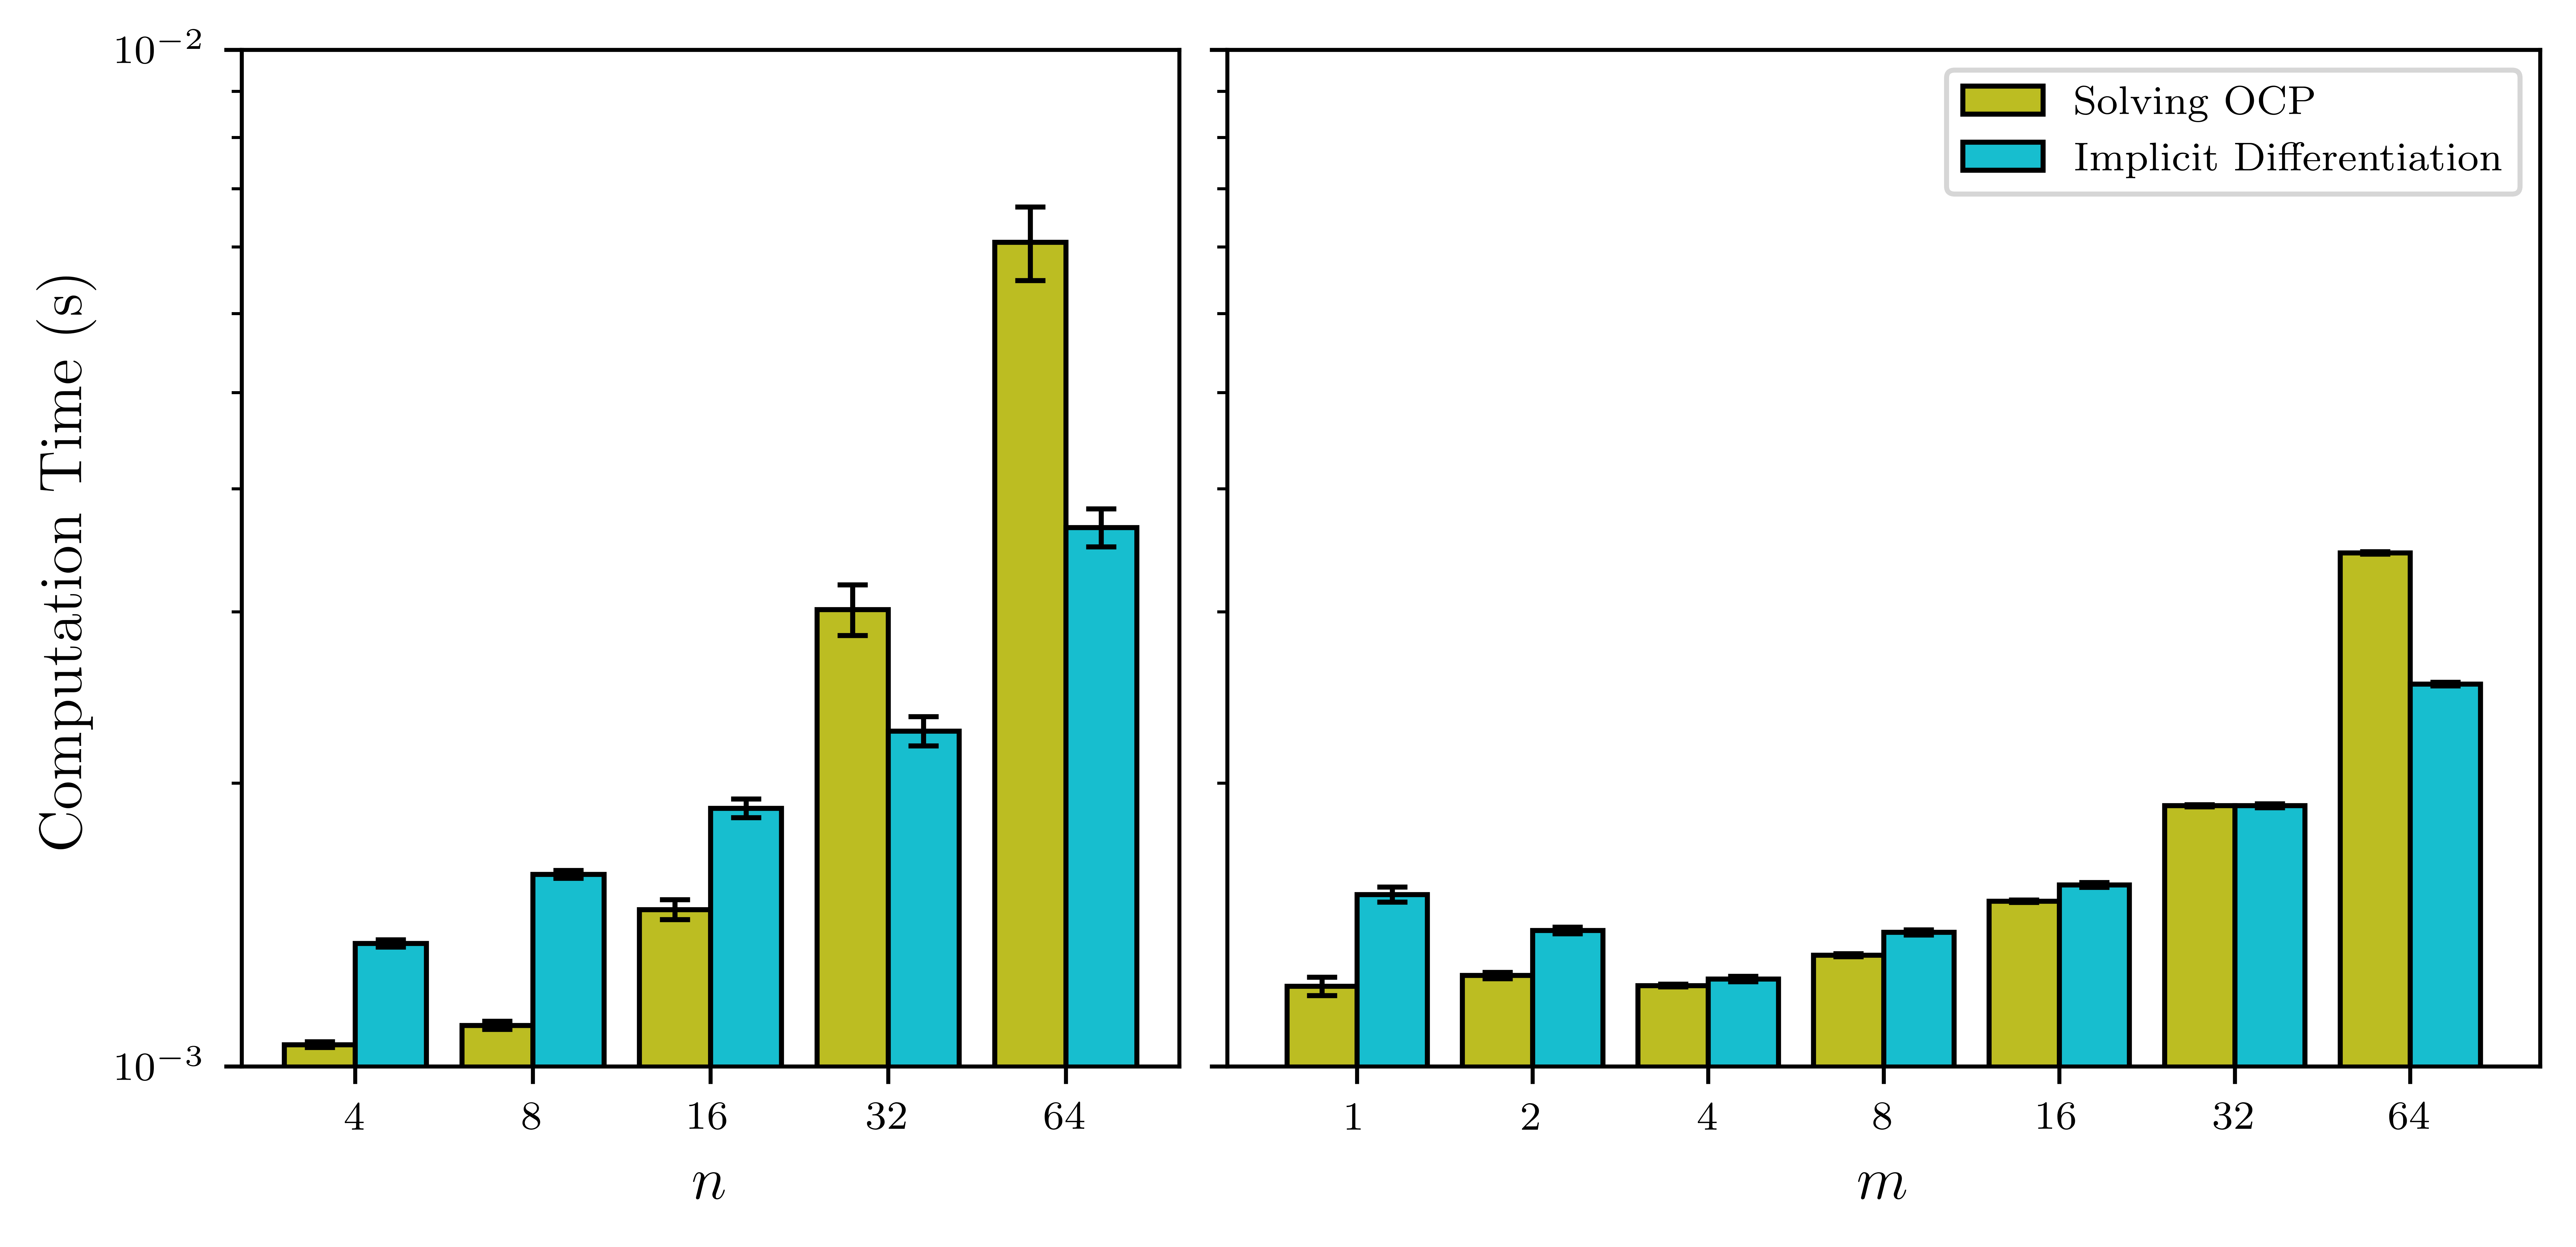

In [10]:
plot_2xdouble_bar(N, n_data, "n", M, m_data, "m", w=0.4, fn = fig_save_dir / "state-input_n-m_2xdouble_bar_plot.png")

# Quadruple tank system

### Constraints

In [11]:
cfg = parse_cfg(work_dir.parents[0] / "cfgs" / 'QT_base.yaml')
save_dir = work_dir / "visualization" / "sample_figures" / "t_do-mpc"
Path.mkdir(save_dir, exist_ok=True)

model = quad_tank_model()
env = make_env(cfg, model)
diffkwargs = {'check_LICQ': False, 'check_rank': False, 'lin_solver': 'scipy', 'lstsq_fallback': True}

con_mpc = construct_con_mpc(cfg, model)
con_mpc_diff = do_mpc.differentiator.DoMPCDifferentiator(con_mpc, **diffkwargs)

uncon_mpc = construct_uncon_mpc(cfg, model)
uncon_mpc_diff = do_mpc.differentiator.DoMPCDifferentiator(uncon_mpc, **diffkwargs)

In [12]:
set_seed(42)
T = env.T
n_traj_samples = 8
n_samples = n_traj_samples*T
con_timings = np.zeros((2, 2, n_samples))

for i, (mpc, mpc_diff) in enumerate(zip([uncon_mpc, con_mpc], [uncon_mpc_diff, con_mpc_diff])):
    for j in range(n_traj_samples):
        x0 = env.reset(batch_size=1)
        mpc.t0 = 0.
        mpc.x0 = x0.T
        mpc.set_initial_guess() 
        for t in range(env.T):
            # mpc.t0 = 0
            # mpc.x0 = x0
            # mpc.set_initial_guess() 
            start = time.time()
            u = mpc.make_step(x0)
            t_soln = time.time() - start
            start = time.time()
            mpc_diff.differentiate()
            t_diff = time.time() - start
            con_timings[i,:,j*T+t] = np.array([
                t_soln,
                t_diff,            
            ])

            w=np.random.normal(0, 0, size=(1,cfg.n))
            v=np.random.normal(0, 0, size=(1,cfg.n))
            x0, r, done = env.step(u.T, w, v)

np.save(data_save_dir / "constraint_timings", con_timings, allow_pickle=False)

ERROR:root:Factor is exactly singular
Traceback (most recent call last):
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/do_mpc/differentiator/_nlpdifferentiator.py", line 486, in _solve_linear_system
    param_sens = sp_sparse.linalg.spsolve(A_num.tocsc(),-B_num.tocsc())
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 302, in spsolve
    Afactsolve = factorized(A)
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 603, in factorized
    return splu(A).solve
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 438, in splu
    return _superlu.gstrf(N, A.nnz, A.data, indices, indptr,
RuntimeError: Factor is exactly singular
ERROR:root:Factor is exactly singular
Traceback (most recent call last):
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-pack

In [13]:
con_timings = np.load(data_save_dir / "constraint_timings.npy")
avg_con_timings = np.average(con_timings,axis=-1)
std_con_timings = np.std(con_timings,axis=-1)
data = {
    r"Solving OCP": con_timings[:,0],
    r"Implicit Differentiation": con_timings[:,1]  
}

# plot_double_bar(methods=["Without Constraints", "With Constraints"], data=data, xlabel=" ", w=0.4, fn = save_dir / "constraint_double_bar_plot.png", lloc="upper right")

### Linearization

In [14]:
cfg = parse_cfg(work_dir.parents[0] / "cfgs" / 'QT_base.yaml')
model = quad_tank_model()
env = make_env(cfg, model)

nl_model = quad_tank_model()
nl_mpc = construct_con_mpc(cfg, nl_model)
nl_mpc_diff = do_mpc.differentiator.DoMPCDifferentiator(nl_mpc, **diffkwargs)

ln_model = linear_quad_tank_model()
ln_mpc = construct_uncon_mpc(cfg, ln_model)
ln_mpc_diff = do_mpc.differentiator.DoMPCDifferentiator(ln_mpc, **diffkwargs)

In [15]:
set_seed(42)
T = env.T
nl_timings = np.zeros((2, 2, n_samples))

for i, (mpc, mpc_diff) in enumerate(zip([ln_mpc, nl_mpc], [ln_mpc_diff, nl_mpc_diff])):
    for j in range(n_traj_samples):
        x0 = env.reset(batch_size=1)
        mpc.t0 = 0.
        mpc.x0 = x0.T
        mpc.set_initial_guess() 
        for t in range(env.T):
            # mpc.t0 = 0
            # mpc.x0 = x0
            # mpc.set_initial_guess() 
            start = time.time()
            u = mpc.make_step(x0)
            t_soln = time.time() - start
            start = time.time()
            mpc_diff.differentiate()
            t_diff = time.time() - start
            nl_timings[i,:,j*T+t] = np.array([
                t_soln,
                t_diff,            
            ])

            w=np.random.normal(0, 0., size=(1,cfg.n))
            v=np.random.normal(0, 0., size=(1,cfg.n))
            x0, r, done = env.step(u.T, w, v)

np.save(data_save_dir / "linearity_timings", nl_timings, allow_pickle=False)

ERROR:root:Factor is exactly singular
Traceback (most recent call last):
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/do_mpc/differentiator/_nlpdifferentiator.py", line 486, in _solve_linear_system
    param_sens = sp_sparse.linalg.spsolve(A_num.tocsc(),-B_num.tocsc())
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 302, in spsolve
    Afactsolve = factorized(A)
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 603, in factorized
    return splu(A).solve
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py", line 438, in splu
    return _superlu.gstrf(N, A.nnz, A.data, indices, indptr,
RuntimeError: Factor is exactly singular
ERROR:root:Factor is exactly singular
Traceback (most recent call last):
  File "/Users/tommy/anaconda3/envs/casadi/lib/python3.10/site-pack

In [16]:
nl_timings = np.load(data_save_dir / "linearity_timings.npy")
avg_nl_timings = np.average(nl_timings,axis=-1)
std_nl_timings = np.std(nl_timings,axis=-1)
data = {
    r"Solving OCP": nl_timings[:,0],
    r"Implicit Differentiation": nl_timings[:,1]  
}

# plot_double_bar(methods=["Linearized Model", "Nonlinear Model"], data=data, xlabel=" ", w=0.4, fn = save_dir / "linearity_double_bar_plot.png", lloc="upper right")

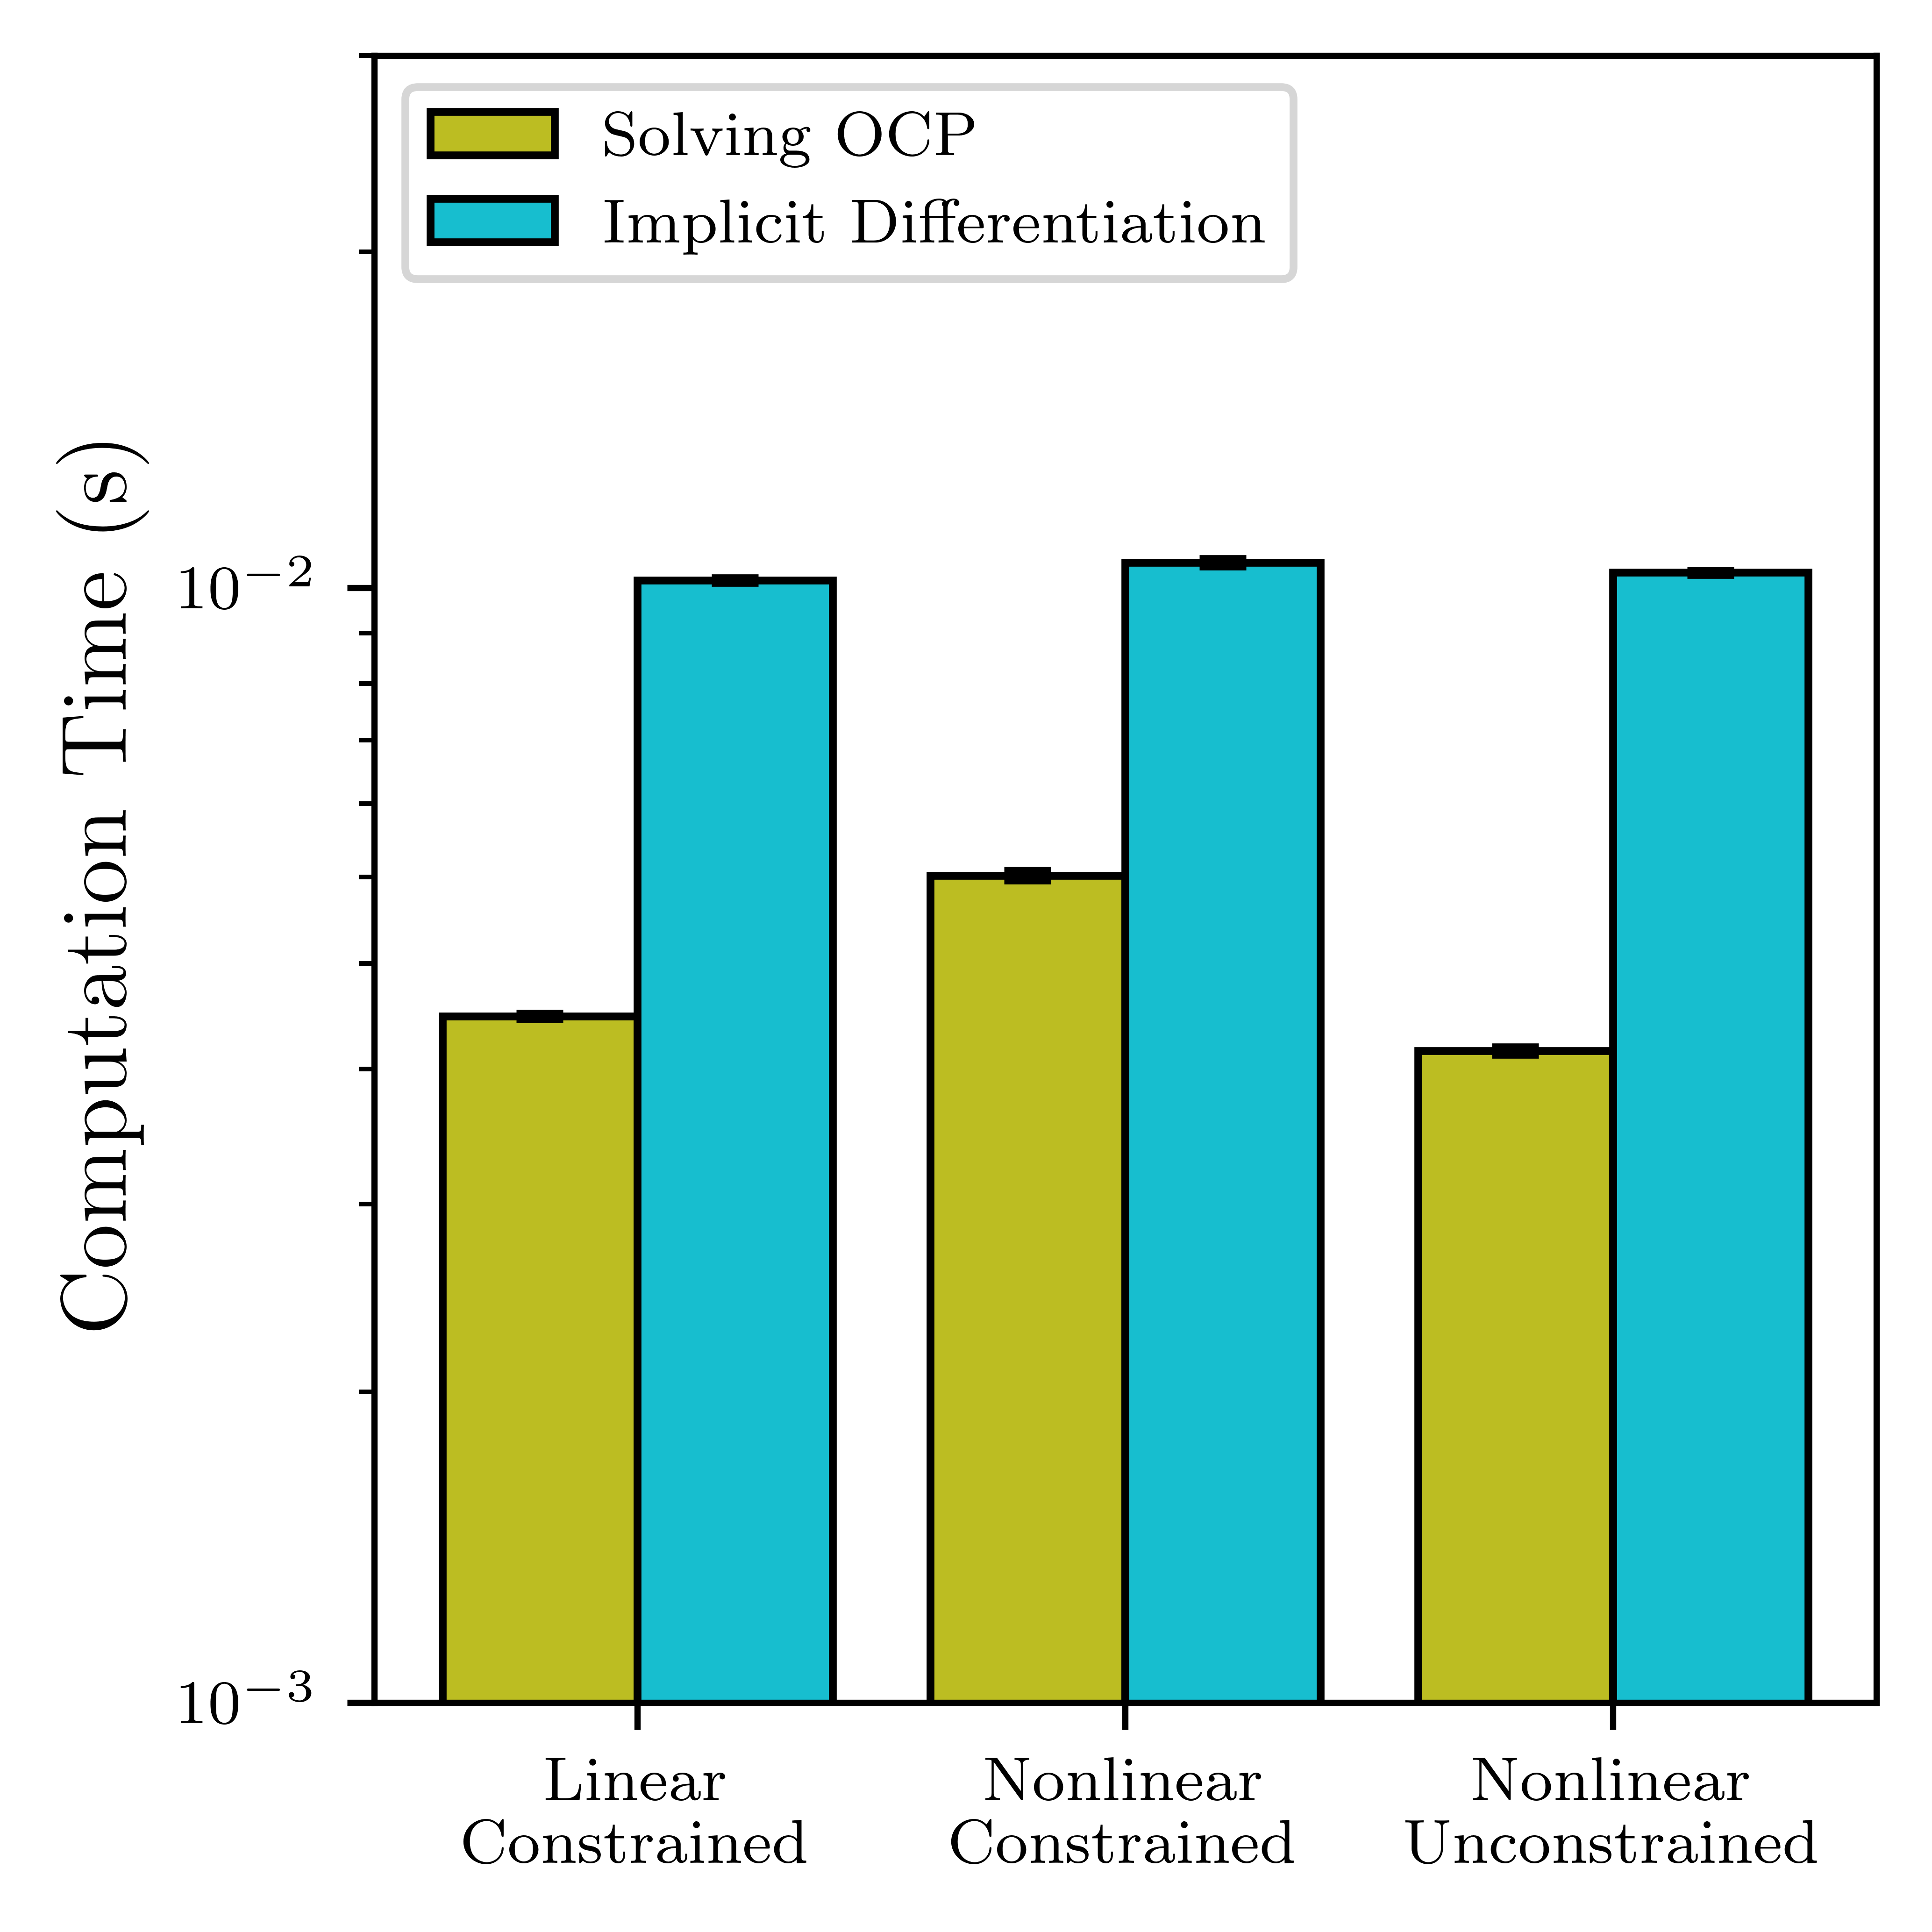

In [17]:
data = {
    r"Solving OCP": np.concatenate([nl_timings[:,0], con_timings[0:1,0]], axis=0),
    r"Implicit Differentiation": np.concatenate([nl_timings[:,1], con_timings[0:1,1]], axis=0)    
}

plot_double_bar(methods=["Linear \n Constrained", "Nonlinear \n Constrained", "Nonlinear \n Unconstrained"], data=data, xlabel=" ", w=0.4, logy=True, fn = fig_save_dir / "constraint_linearity_double_bar_plot.png", lloc="upper left")